In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
from volsense_pkg.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
from volsense_pkg.models.garch_baseline import fit_garch, forecast_garch
from volsense_pkg.utils.metrics import rolling_garch_forecast, evaluate_forecasts

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5071.98
Distribution:                  Normal   AIC:                           10150.0
Method:            Maximum Likelihood   BIC:                           10168.8
                                        No. Observations:                 3924
Date:                Wed, Sep 10 2025   Df Residuals:                     3924
Time:                        12:39:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0354  7.188e-03      4.927  8.330e-07 [2.

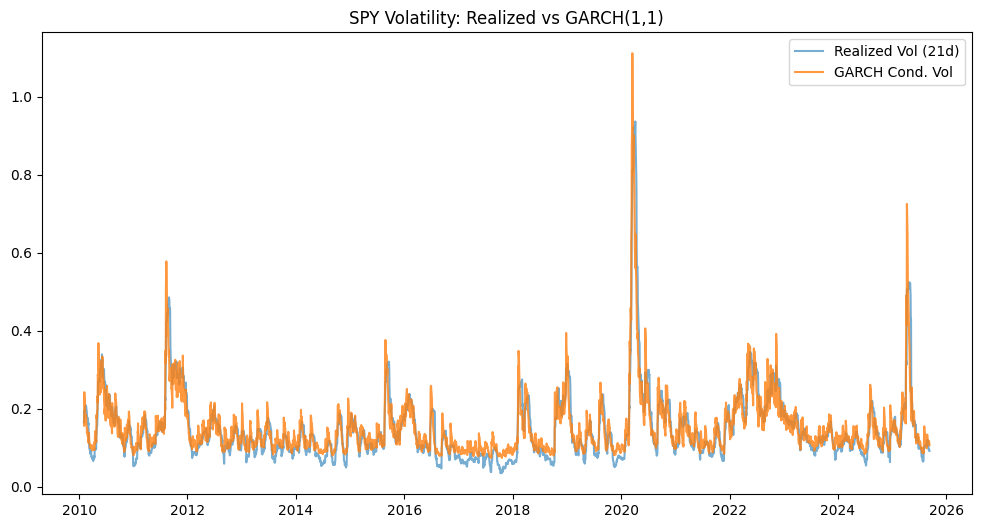

In [2]:
# === Fetch data ===
ticker = "SPY"
df = fetch_ohlcv(ticker, start="2010-01-01")
df = compute_returns_vol(df, window=21)

# === Fit GARCH(1,1) ===
returns = df["return"].dropna()
fitted = fit_garch(returns)

print(fitted.summary())

# === Forecast 5 days ahead ===
vol_forecast = forecast_garch(fitted, horizon=5)
print("5-day ahead forecast (annualized):")
print(vol_forecast)

# === Plot fitted conditional volatility vs realized ===
cond_vol = fitted.conditional_volatility / 100 * (252 ** 0.5)  # annualized
df["garch_vol"] = cond_vol

plt.figure(figsize=(12,6))
plt.plot(df.index, df["vol_realized"], label="Realized Vol (21d)", alpha=0.6)
plt.plot(df.index, df["garch_vol"], label="GARCH Cond. Vol", alpha=0.8)
plt.title(f"{ticker} Volatility: Realized vs GARCH(1,1)")
plt.legend()
plt.show()


In [3]:
# === Data ===
ticker = "SPY"
df = fetch_ohlcv(ticker, start="2010-01-01")
df = compute_returns_vol(df, window=21)

# === Rolling backtest ===
returns = df["return"]
results = rolling_garch_forecast(returns, window=1000, horizon=1)
#results.dropna(inplace=True)
results

,forecast_vol,realized_vol
date,,
2014-01-24,0.112008,0.342368
2014-01-27,0.158225,0.078286
2014-01-28,0.150439,0.094249
2014-01-29,0.145607,0.153213
2014-01-30,0.146977,0.167393
...,...,...
2025-09-03,0.119412,0.085800
2025-09-04,0.118122,0.132119
2025-09-05,0.121655,0.046043


In [4]:
# === Evaluate ===
metrics = evaluate_forecasts(results)
print(metrics)

{'RMSE': np.float64(0.1208055487504313), 'MAE': 0.08802102971151368}
